In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os
import random
import pandas as pd
from tqdm import tqdm

import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision

In [ ]:
image_path = './drive/MyDrive/SCR_JSRT/Images/'
mask_path= './drive/MyDrive/SCR_JSRT/combined_mask/combined_heart/'


In [ ]:
# No. of images < masks 
image_list = os.listdir(image_path)

mask_list = [filename for filename in image_list]
print(len(image_list))
print(len(mask_list))

241
241


In [ ]:
for i in range(len(image_list)):
  print(image_list[i],"----",mask_list[i])


In [ ]:
def getData(shape):
    im_array = []
    mask_array = []
    shape = (shape, shape)
    # shape = image_size
    for i in tqdm(image_list): 
      # im.shape = (shape, shape, 1)
      im = cv2.imread(os.path.join(image_path,i))
      im= cv2.bitwise_not(im)
      im = cv2.resize(im, shape)[:, :, 0]
      im = cv2.equalizeHist(im)
      # mask.shape = (shape, shape, 1)
      mask = cv2.imread(os.path.join(mask_path, i))
      mask = cv2.resize(mask, shape)[:, :, 0]

   
      
      im_array.append(im)
      mask_array.append(mask)

      

    return im_array, mask_array

In [ ]:
cv2.__version__

'4.1.2'

In [ ]:
dim = 512
image_arr, mask_arr = getData(dim)

100%|██████████| 241/241 [03:01<00:00,  1.33it/s]


In [ ]:
image_arr = np.array(image_arr).reshape(len(image_arr), dim, dim, 1)
mask_arr = np.array(mask_arr).reshape(len(mask_arr), dim, dim, 1)

Text(0.5, 1.0, 'mask')

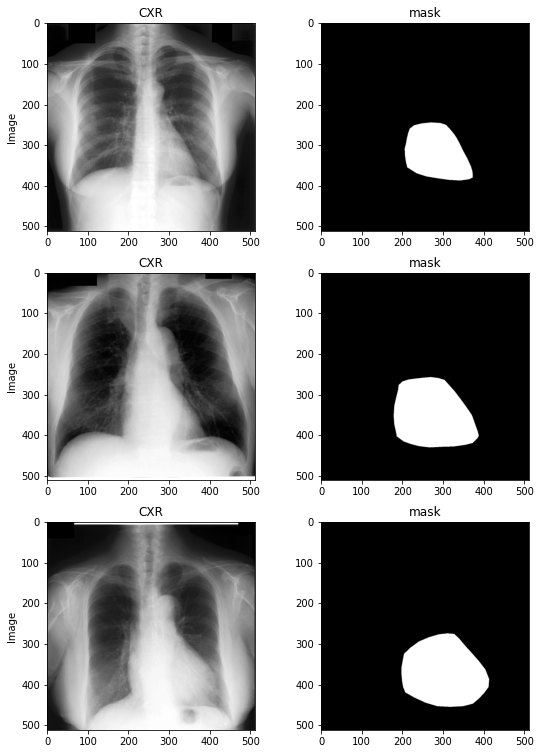

In [ ]:

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(9, 13))
axs[0, 0].imshow(np.squeeze(image_arr[34]), cmap='gray')
axs[0, 1].imshow(np.squeeze(mask_arr[34]), cmap='gray')
axs[0, 0].set_ylabel('Image')

axs[1, 0].imshow(np.squeeze(image_arr[205]), cmap='gray')
axs[1, 1].imshow(np.squeeze(mask_arr[205]), cmap='gray')
axs[1, 0].set_ylabel('Image')

axs[2, 0].imshow(np.squeeze(image_arr[150]), cmap='gray')
axs[2, 1].imshow(np.squeeze(mask_arr[150]), cmap='gray')
axs[2, 0].set_ylabel('Image')

axs[0, 0].set_title('CXR')
axs[1, 0].set_title('CXR')
axs[2, 0].set_title('CXR')

axs[0, 1].set_title('mask')
axs[1, 1].set_title('mask')
axs[2,1].set_title('mask')




In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split((image_arr - 127.0) / 127.0, 
                                                  (mask_arr > 127).astype(np.float32), 
                                                  test_size = 0.1, 
                                                  random_state = 42)
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)

(216, 512, 512, 1) (25, 512, 512, 1) (216, 512, 512, 1) (25, 512, 512, 1)


# IMPLEMENTATION 1

In [ ]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
model = unet(input_size=(512,512,1))
model.compile(optimizer=Adam(lr=2e-4), loss=dice_loss,
                  metrics=[dice_coef, iou])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
weight_path="{}_weights.best.hdf5".format('cxr_heart')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) 
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
h = model.fit(X_train, Y_train, 
                validation_data=(X_val, Y_val), 
                batch_size=16, epochs=50,
                callbacks= callbacks_list)

Epoch 1/50
 2/14 [===>..........................] - ETA: 22:54 - loss: 0.8502 - dice_coef: 0.1498 - iou: 0.0810

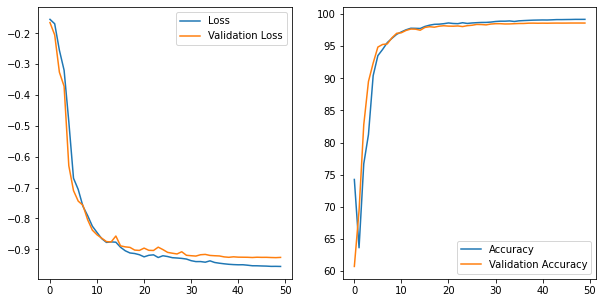

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(h.history['loss'], '-', label = 'Loss')
ax1.plot(h.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100 * np.array(h.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100 * np.array(h.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend();

# IMPLEMENTAION 2

In [ ]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
model = build_unet(input_shape=(512,512,1))
model.compile(optimizer=Adam(lr=2e-4), loss=dice_loss,
                  metrics=[dice_coef, iou, Recall(), Precision()])
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
weight_path="{}_weights.best.hdf5".format('cxr_heart')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', min_delta=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) 
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
h = model.fit(X_train, Y_train, 
                validation_data=(X_val, Y_val), 
                batch_size=4, epochs=50,
                callbacks= callbacks_list)

Epoch 1/50
54/54 [==============================] - ETA: 0s - loss: 0.5212 - dice_coef: 0.4788 - iou: 0.3243 - recall: 0.8848 - precision: 0.3778
Epoch 00001: val_loss improved from inf to 0.82613, saving model to cxr_heart_weights.best.hdf5
54/54 [==============================] - 154s 3s/step - loss: 0.5212 - dice_coef: 0.4788 - iou: 0.3243 - recall: 0.8848 - precision: 0.3778 - val_loss: 0.8261 - val_dice_coef: 0.1795 - val_iou: 0.0987 - val_recall: 1.0000 - val_precision: 0.0952 - lr: 2.0000e-04
Epoch 2/50
54/54 [==============================] - ETA: 0s - loss: 0.3145 - dice_coef: 0.6855 - iou: 0.5237 - recall: 0.9093 - precision: 0.7717
Epoch 00002: val_loss improved from 0.82613 to 0.82326, saving model to cxr_heart_weights.best.hdf5
54/54 [==============================] - 151s 3s/step - loss: 0.3145 - dice_coef: 0.6855 - iou: 0.5237 - recall: 0.9093 - precision: 0.7717 - val_loss: 0.8233 - val_dice_coef: 0.1824 - val_iou: 0.1005 - val_recall: 1.0000 - val_precision: 0.0971 - l

In [ ]:
def get_test(X_shape, n_samples = 5):
    im_array = []
    shape = (X_shape, X_shape)
    test_files = random.choices(list(os.listdir("/content/drive/MyDrive/Aortic Enlargement/images/val")), k=n_samples)
    for i in tqdm(test_files):
        im = cv2.imread(os.path.join("/content/drive/MyDrive/Aortic Enlargement/images/val", i))
        im = cv2.resize(im, shape)[:, :, 0]
        im = cv2.equalizeHist(im)
        im_array.append(im)
    return im_array

In [ ]:
dim, n_samples = 512, 5
X_test = get_test(dim, n_samples = n_samples)
X_test = np.array(X_test).reshape(len(X_test), dim, dim, 1)
X_testNorm = (X_test - 127.0) / 127.0



100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


# HEART TESTING

In [ ]:
model.load_weights('/content/drive/MyDrive/Model_Weights/cxr_heart_weights.best(3).hdf5')
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

Text(0.5, 1.0, 'predicted mask')

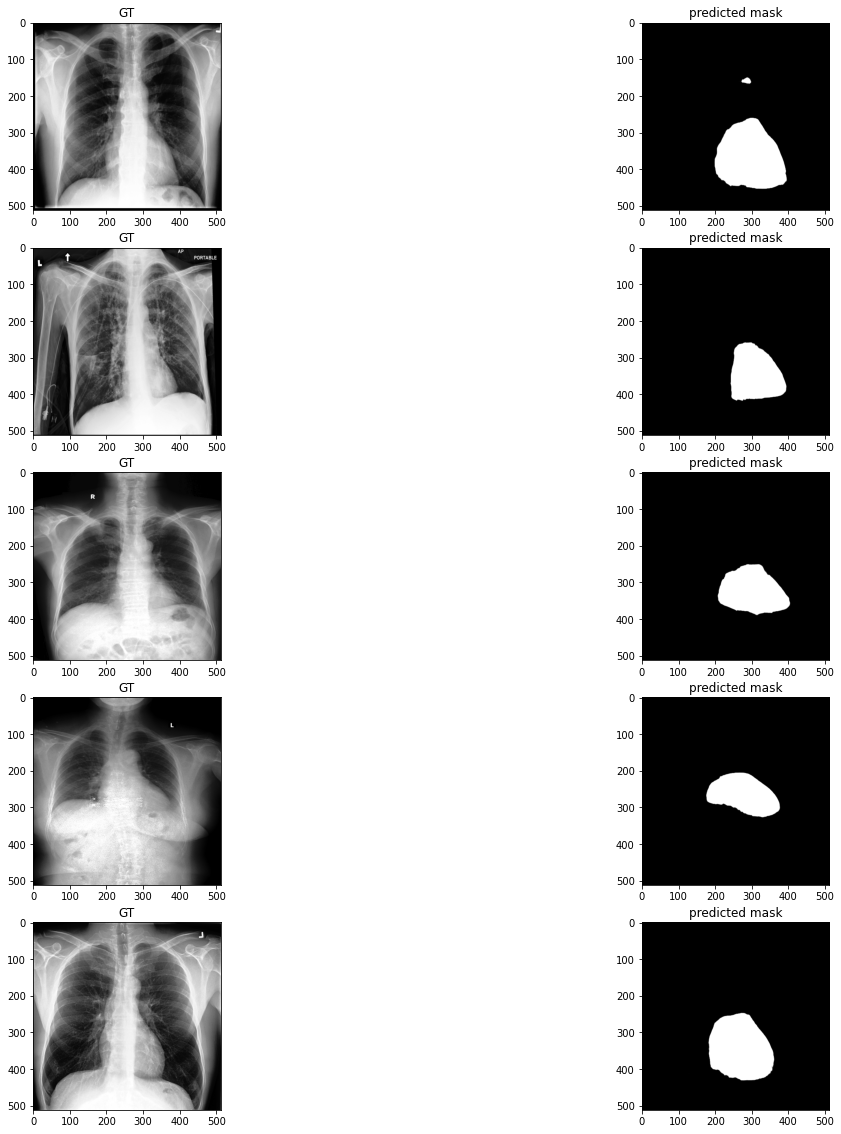

In [ ]:
preds = model.predict(X_testNorm)
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(20, 20))

axs[0, 0].imshow(np.squeeze(X_testNorm[0]), cmap='gray')
axs[0, 0].set_title('GT')

axs[0, 1].imshow(np.squeeze(preds[0]), cmap='gray')
axs[0, 1].set_title('predicted mask')

axs[1, 0].imshow(np.squeeze(X_testNorm[1]), cmap='gray')
axs[1, 0].set_title('GT')

axs[1, 1].imshow(np.squeeze(preds[1]), cmap='gray')
axs[1, 1].set_title('predicted mask')

axs[2, 0].imshow(np.squeeze(X_testNorm[2]), cmap='gray')
axs[2, 0].set_title('GT')

axs[2, 1].imshow(np.squeeze(preds[2]), cmap='gray')
axs[2, 1].set_title('predicted mask')

axs[3, 0].imshow(np.squeeze(X_testNorm[3]), cmap='gray')
axs[3, 0].set_title('GT')

axs[3, 1].imshow(np.squeeze(preds[3]), cmap='gray')
axs[3, 1].set_title('predicted mask')

axs[4, 0].imshow(np.squeeze(X_testNorm[4]), cmap='gray')
axs[4, 0].set_title('GT')

axs[4, 1].imshow(np.squeeze(preds[4]), cmap='gray')
axs[4, 1].set_title('predicted mask')